In [42]:
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [43]:
train_df = pd.read_csv('/content/fashion-mnist_train.csv',sep=',')
test_df = pd.read_csv('/content/fashion-mnist_test.csv', sep = ',')

In [44]:
train_data= np.array(train_df, dtype= 'float32')
test_data= np.array(test_df, dtype= 'float32')

In [45]:
x_train = train_data[:,1:]/255
y_train = train_data[:,0]
x_test= test_data[:,1:]/255
y_test=test_data[:,0]

In [46]:
x_train,x_validate,y_train,y_validate = train_test_split(x_train,y_train,test_size = 0.2,random_state = 12345)
x_train.shape, x_validate.shape,y_train.shape,y_validate.shape

((48000, 784), (12000, 784), (48000,), (12000,))

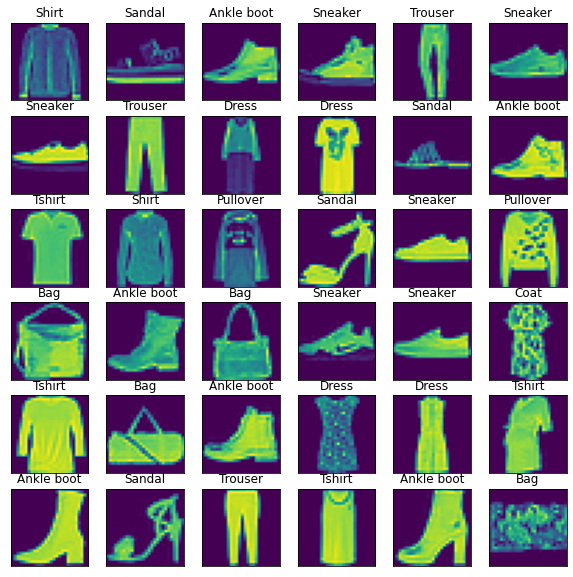

In [47]:
class_names= ['Tshirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i].reshape((28,28)))
    label_index= int(y_train[i])
    plt.title(class_names[label_index])
plt.show()

In [48]:
batch_size = 4096

x_train = x_train.reshape(-1, 28, 28, 1)
x_test= x_test.reshape(-1, 28, 28, 1)
x_validate = x_validate.reshape(-1, 28, 28, 1)
x_train.shape, x_test.shape, x_validate.shape

((48000, 28, 28, 1), (10000, 28, 28, 1), (12000, 28, 28, 1))

In [49]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [4825, 4823, 4813, 4783, 4807, 4784, 4801, 4787, 4782, 4795]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [50]:
def gen_random_batch(in_groups, batch_halfsize=8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size=batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

In [51]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout

img_in = Input(shape=x_train.shape[1:], name='FeatureNet_ImageInput')
n_layer = img_in
n_layer = Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation= 'relu', input_shape= image_shape)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(n_layer)
n_layer = Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding='same')(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(n_layer)
n_layer = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same')(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same')(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same')(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(n_layer)
n_layer = Flatten()(n_layer)
n_layer = Dense(4096, activation='relu')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = Dense(4096, activation='relu')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = Dense(10, activation='softmax')(n_layer)

feature_model = Model(inputs=[img_in], outputs=[n_layer], name='FeatureGenerationModel')
feature_model.summary()

Model: "FeatureGenerationModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FeatureNet_ImageInput (Inpu  [(None, 28, 28, 1)]      0         
 tLayer)                                                         
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_9 (Batc  (None, 5, 5, 96)         384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 3, 3, 96)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 3, 3, 256)         614656    
                                            

In [52]:
from keras.layers import concatenate
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout

img_a_in = Input(shape=x_train.shape[1:], name='ImageA_Input')
img_b_in = Input(shape=x_train.shape[1:], name='ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name='merge_features')
combined_features = Dense(16, activation='linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation='linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation='sigmoid')(combined_features)
similarity_model = Model(inputs=[img_a_in, img_b_in], outputs=[combined_features], name='Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 FeatureGenerationModel (Functi  (None, 10)          21604426    ['ImageA_Input[0][0]',           
 onal)                                                            'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 20)           0           ['FeatureGeneratio

In [53]:
# setup the optimization process
from tensorflow.keras.optimizers import Adam,SGD
opt = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
similarity_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'mae'])

In [54]:
def find_simmilar(dataset, image, n_candidates=1024, finalists=4):
    candidates, preds = [], []
    for i in range(n_candidates):
        candidates.append(dataset[np.random.choice(range(len(dataset)))])
    compiled = [np.tile(image, (n_candidates, 1, 1, 1)), np.stack(candidates)]
    print(compiled[0].shape, compiled[1].shape)
    preds = similarity_model.predict(compiled).reshape(-1)
    print(preds.shape)
    top = np.argpartition(preds, -finalists)[-finalists:]
    for i in top:
        plt.imshow(candidates[i][:, :, 0])
        plt.show()
        print(preds[i])

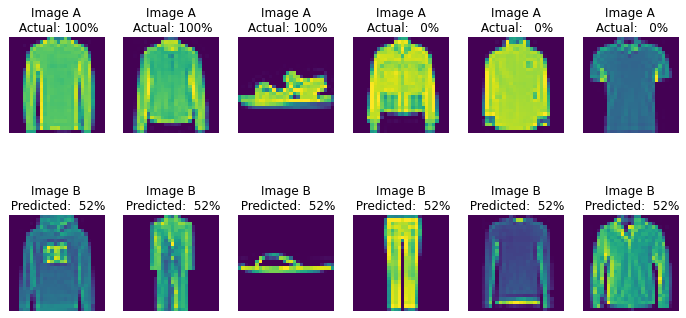

In [55]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [56]:
def siam_gen(in_groups, batch_size=32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit(
    siam_gen(train_groups),
    steps_per_epoch=500,
    validation_data=([valid_a, valid_b], valid_sim),
    epochs=10,
    verbose=True
)

Epoch 1/10
500/500 [==============================] - 576s 1s/step - loss: 0.6122 - accuracy: 0.6352 - mae: 0.4302 - val_loss: 0.5035 - val_accuracy: 0.7266 - val_mae: 0.3414
Epoch 2/10
500/500 [==============================] - 574s 1s/step - loss: 0.5145 - accuracy: 0.7406 - mae: 0.3469 - val_loss: 0.4997 - val_accuracy: 0.7520 - val_mae: 0.3387
Epoch 3/10
500/500 [==============================] - 570s 1s/step - loss: 0.4718 - accuracy: 0.7631 - mae: 0.3213 - val_loss: 0.4416 - val_accuracy: 0.7832 - val_mae: 0.3016
Epoch 4/10
500/500 [==============================] - 575s 1s/step - loss: 0.4378 - accuracy: 0.7832 - mae: 0.2935 - val_loss: 0.4318 - val_accuracy: 0.7896 - val_mae: 0.2845
Epoch 5/10
500/500 [==============================] - 566s 1s/step - loss: 0.4244 - accuracy: 0.7914 - mae: 0.2836 - val_loss: 0.4372 - val_accuracy: 0.7832 - val_mae: 0.2921
Epoch 6/10
500/500 [==============================] - 578s 1s/step - loss: 0.4335 - accuracy: 0.7823 - mae: 0.2909 - val_loss

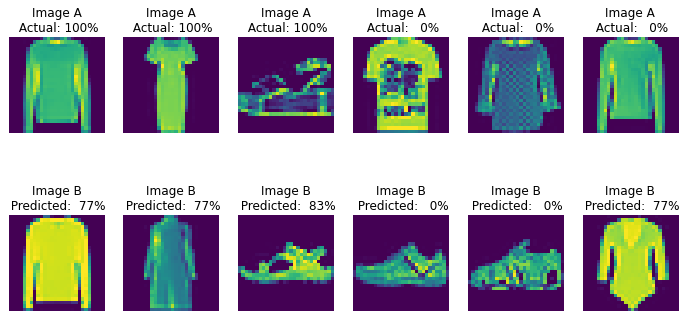

In [57]:
_ = show_model_output()

In [58]:
image = x_train[345]

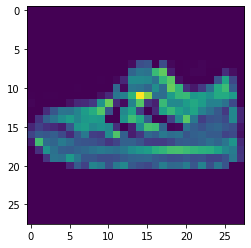

In [59]:
plt.imshow(image[:, :, 0])

(1024, 28, 28, 1) (1024, 28, 28, 1)
(1024,)


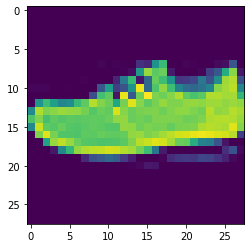

0.8317412


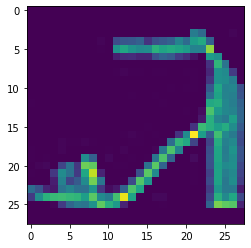

0.8317412


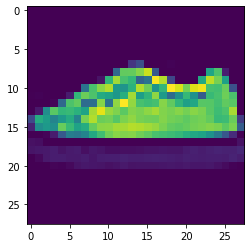

0.8348291


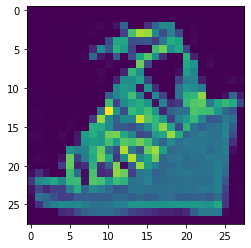

0.8391452


In [60]:
find_simmilar(x_train, image)

In [61]:
t_shirt_vec = np.stack([train_groups[0][0]]*x_test.shape[0], 0)
t_shirt_score = similarity_model.predict([t_shirt_vec, x_test], verbose=True, batch_size=128)
ankle_boot_vec = np.stack([train_groups[-1][0]]*x_test.shape[0], 0)
ankle_boot_score = similarity_model.predict([ankle_boot_vec, x_test], verbose=True, batch_size=128)

79/79 [==============================] - 27s 344ms/step


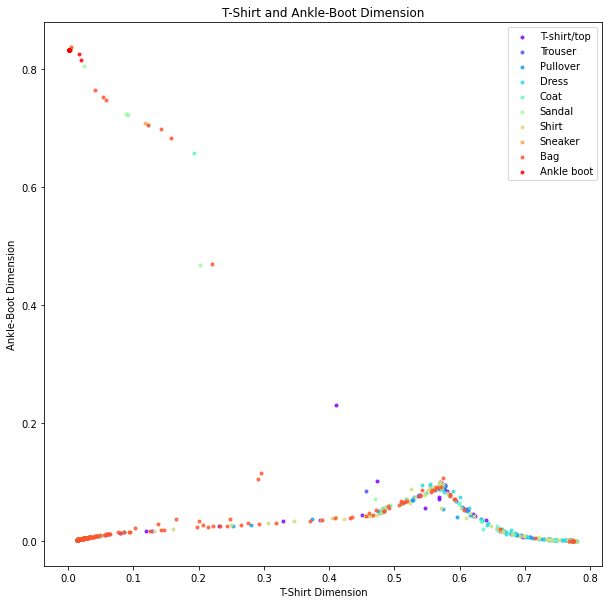

In [62]:
obj_categories = [
    'T-shirt/top','Trouser','Pullover','Dress',
    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(
        t_shirt_score[np.where(y_test == c_group), 0],
        ankle_boot_score[np.where(y_test == c_group), 0],
        marker='.',
        color=c_color,
        linewidth='1',
        alpha=0.8,
        label=c_label
    )
plt.xlabel('T-Shirt Dimension')
plt.ylabel('Ankle-Boot Dimension')
plt.title('T-Shirt and Ankle-Boot Dimension')
plt.legend(loc='best')
plt.savefig('tshirt-boot-dist.png')
plt.show(block=False)

In [63]:
x_test_features = feature_model.predict(
    x_test,
    verbose=True,
    batch_size=128
)

79/79 [==============================] - 14s 176ms/step


In [64]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(
    n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=2
)
tsne_features = tsne_obj.fit_transform(x_test_features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.013s...
[t-SNE] Computed neighbors for 10000 samples in 0.392s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 1.846s


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 76.6866150, gradient norm = 0.0195730 (50 iterations in 3.493s)
[t-SNE] Iteration 100: error = 66.1844177, gradient norm = 0.0314590 (50 iterations in 3.489s)
[t-SNE] Iteration 150: error = 60.6719322, gradient norm = 0.0038763 (50 iterations in 3.885s)
[t-SNE] Iteration 200: error = 58.7225113, gradient norm = 0.0024240 (50 iterations in 3.740s)
[t-SNE] Iteration 250: error = 57.4219742, gradient norm = 0.0019189 (50 iterations in 3.614s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.421974
[t-SNE] Iteration 300: error = 1.7139139, gradient norm = 0.0011532 (50 iterations in 3.766s)
[t-SNE] Iteration 350: error = 1.2347164, gradient norm = 0.0005963 (50 iterations in 3.730s)
[t-SNE] Iteration 400: error = 0.9700538, gradient norm = 0.0003595 (50 iterations in 3.625s)
[t-SNE] Iteration 450: error = 0.8162590, gradient norm = 0.0002451 (50 iterations in 3.607s)
[t-SNE] Iteration 500: error = 0.7166152, gradient norm = 0.0001825 (50 

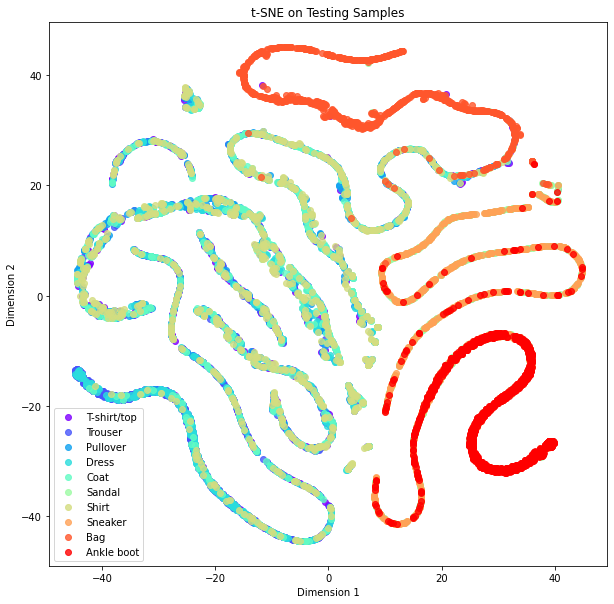

In [65]:
obj_categories = [
    'T-shirt/top','Trouser','Pullover','Dress',
    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(
        tsne_features[np.where(y_test == c_group), 0],
        tsne_features[np.where(y_test == c_group), 1],
        marker='o',
        color=c_color,
        linewidth='1',
        alpha=0.8,
        label=c_label
    )
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)